In [87]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from statsmodels.tsa.stattools import kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_predict

In [101]:
dataframe = pd.read_csv('https://www.lombacovid.it/story.csv')
timeseries = dataframe['ospedalizzati_story']

timeseries.describe()

count     699.000000
mean     2310.104435
std      2367.047721
min       155.000000
25%       472.500000
50%      1197.000000
75%      3867.000000
max      9340.000000
Name: ospedalizzati_story, dtype: float64

Tipically the logged timeseries is more stationary

Text(0.5, 1.0, 'Logged data (deflated)')

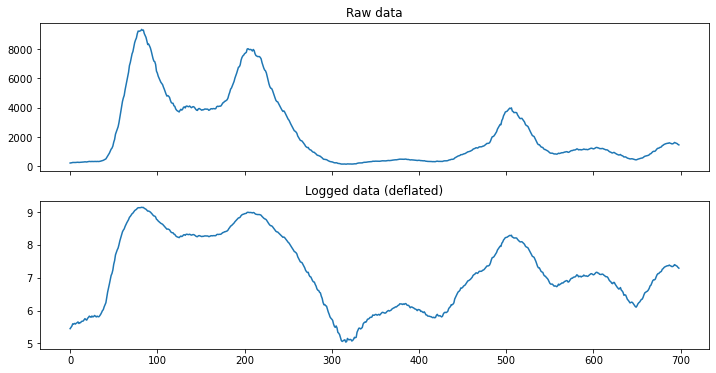

In [89]:
fig, ax = plt.subplots(2, sharex=True, figsize=(12,6))
ax[0].plot(timeseries.values)
ax[0].set_title("Raw data")
ax[1].plot(np.log(timeseries.values))
ax[1].set_title("Logged data (deflated)")

The logged series seems to be more flat, but is it stationary ? Let’s compute a KPSS test to check this:

In [90]:
print(" > Is the data stationary ?")
dftest = kpss(np.log(timeseries), 'ct')
print("Test statistic = {:.3f}".format(dftest[0]))
print("P-value = {:.3f}".format(dftest[1]))
print("Critical values :")
for k, v in dftest[3].items():
    print("\t{}: {}".format(k, v))

 > Is the data stationary ?
Test statistic = 0.277
P-value = 0.010
Critical values :
	10%: 0.119
	5%: 0.146
	2.5%: 0.176
	1%: 0.216


/Users/stefanomartire/miniforge3/envs/lombacovid/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


Rule 1 : If the series has positive autocorrelations out to a high number of lags, then it probably needs a higher order of differencing.

Rule 2 : If the lag-1 autocorrelation is zero or negative, or the autocorrelations are all small and patternless, then the series does not need a higher order of differencing. If the lag-1 autocorrelation is -0.5 or more negative, the series may be overdifferenced.

/Users/stefanomartire/miniforge3/envs/lombacovid/lib/python3.8/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


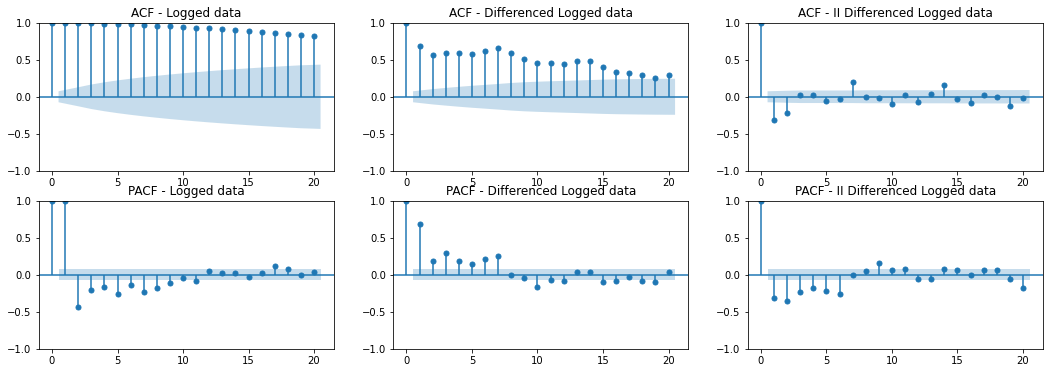

In [91]:
fig, ax = plt.subplots(2, 3, figsize=(18,6))
first_diff = (np.log(timeseries)- np.log(timeseries).shift()).dropna()
second_diff = (first_diff- first_diff.shift()).dropna()
ax[0, 0] = plot_acf(np.log(timeseries), ax=ax[0, 0], lags=20, title="ACF - Logged data")
ax[1, 0] = plot_pacf(np.log(timeseries), ax=ax[1, 0], lags=20, title="PACF - Logged data")
ax[0, 1] = plot_acf(first_diff , ax=ax[0, 1], lags=20, title="ACF - Differenced Logged data")
ax[1, 1] = plot_pacf(first_diff, ax=ax[1, 1], lags=20, title="PACF - Differenced Logged data")
ax[0, 2] = plot_acf(second_diff , ax=ax[0, 2], lags=20, title="ACF - II Differenced Logged data")
ax[1, 2] = plot_pacf(second_diff, ax=ax[1, 2], lags=20, title="PACF - II Differenced Logged data")

The “ACF — Logged data” chart shows non-stationary data, characterized by the slow linear decay in the spikes (cf rule 1 above). Adding a 2nd order difference gives a single negative spike at lag value 1. According to rule#2, we don’t need to differentiate the series any further. Let’s check our results by comparing a (0, 0, 0) and a (0, 2, 0) ARIMA model:

                                SARIMAX Results                                
Dep. Variable:     ospedalizzati_story   No. Observations:                  699
Model:                           ARIMA   Log Likelihood               -1069.419
Date:                 Sun, 31 Jul 2022   AIC                           2142.838
Time:                         23:10:15   BIC                           2151.937
Sample:                              0   HQIC                          2146.355
                                 - 699                                         
Covariance Type:                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          7.1763      0.042    169.579      0.000       7.093       7.259
sigma2         1.2485      0.104     11.987      0.000       1.044       1.453
Ljung-Box (L1) (Q):                 698.70  

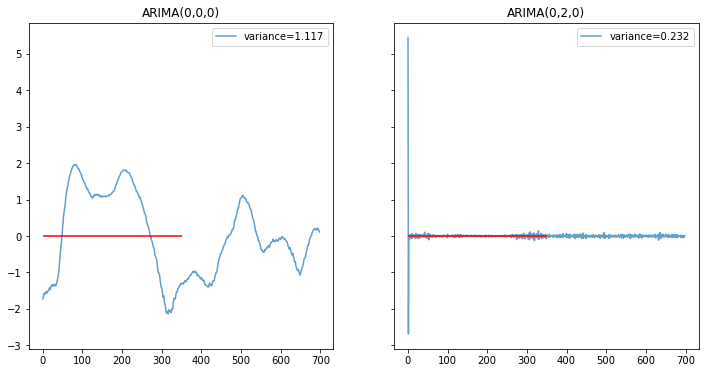

In [92]:
model = ARIMA(endog=np.log(timeseries).dropna(), order=(0, 0, 0))
res_000 = model.fit()
print(res_000.summary())

model = ARIMA(endog=np.log(timeseries).dropna(), order=(0, 2, 0))
res_010 = model.fit()
print(res_010.summary())

fig, ax = plt.subplots(1, 2, sharey=True, figsize=(12, 6))
ax[0].plot(res_000.resid.values, alpha=0.7, label='variance={:.3f}'.format(np.std(res_000.resid.values)))
ax[0].hlines(0, xmin=0, xmax=350, color='r')
ax[0].set_title("ARIMA(0,0,0)")
ax[0].legend()
ax[1].plot(res_010.resid.values, alpha=0.7, label='variance={:.3f}'.format(np.std(res_010.resid.values)))
ax[1].hlines(0, xmin=0, xmax=350, color='r')
ax[1].set_title("ARIMA(0,2,0)")
ax[1].legend()

Now we know we have to include a 2nd order difference in our model, we need to choose the Moving-Average order. This is done by looking at the differenced series. If the lag-1 autocorrelation of the differenced series ACF is negative, and/or there is a sharp cutoff, then choose a MA order of 1, and If we observe autocorrelations at higher lags, and by looking at the autocorrelation residuals of our (0,1,1) model, we still observe these spikes, we can increase our MA order, though is usually not recommended to go beyond 2!

                                SARIMAX Results                                
Dep. Variable:     ospedalizzati_story   No. Observations:                  699
Model:                  ARIMA(0, 2, 1)   Log Likelihood                1527.233
Date:                 Sun, 31 Jul 2022   AIC                          -3050.467
Time:                         23:10:15   BIC                          -3041.373
Sample:                              0   HQIC                         -3046.951
                                 - 699                                         
Covariance Type:                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.7372      0.022    -33.874      0.000      -0.780      -0.695
sigma2         0.0007   2.65e-05     27.531      0.000       0.001       0.001
Ljung-Box (L1) (Q):                   8.88  

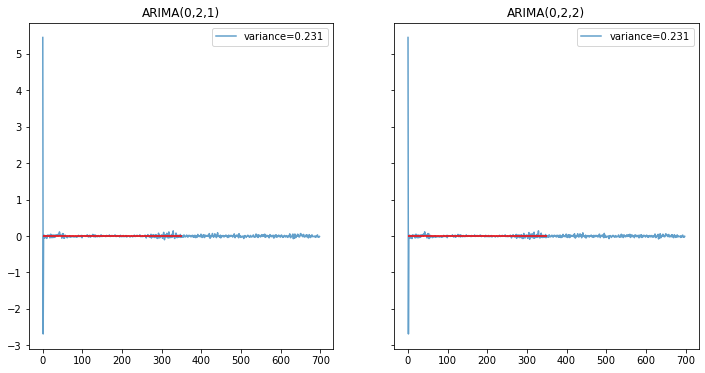

In [93]:
model = ARIMA(endog=np.log(timeseries).dropna(), order=(0, 2, 1))
res_000 = model.fit()
print(res_000.summary())

model = ARIMA(endog=np.log(timeseries).dropna(), order=(0, 2, 2))
res_010 = model.fit()
print(res_010.summary())

fig, ax = plt.subplots(1, 2, sharey=True, figsize=(12, 6))
ax[0].plot(res_000.resid.values, alpha=0.7, label='variance={:.3f}'.format(np.std(res_000.resid.values)))
ax[0].hlines(0, xmin=0, xmax=350, color='r')
ax[0].set_title("ARIMA(0,2,1)")
ax[0].legend()
ax[1].plot(res_010.resid.values, alpha=0.7, label='variance={:.3f}'.format(np.std(res_010.resid.values)))
ax[1].hlines(0, xmin=0, xmax=350, color='r')
ax[1].set_title("ARIMA(0,2,2)")
ax[1].legend()

you should add an AR term If the lag-1 autocorrelation of the differenced series PACF is negative, and/or there is a sharp cutoff, then choose a AR order of 1. the PACF of the differenced series shows six negative spikes , meaning we could in theory push our AR order up to 6

                                SARIMAX Results                                
Dep. Variable:     ospedalizzati_story   No. Observations:                  699
Model:                  ARIMA(1, 2, 1)   Log Likelihood                1533.676
Date:                 Sun, 31 Jul 2022   AIC                          -3061.352
Time:                         23:10:15   BIC                          -3047.712
Sample:                              0   HQIC                         -3056.079
                                 - 699                                         
Covariance Type:                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1637      0.046      3.584      0.000       0.074       0.253
ma.L1         -0.7894      0.028    -28.269      0.000      -0.844      -0.735
sigma2         0.0007   2.61e-05     27.436 

/Users/stefanomartire/miniforge3/envs/lombacovid/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


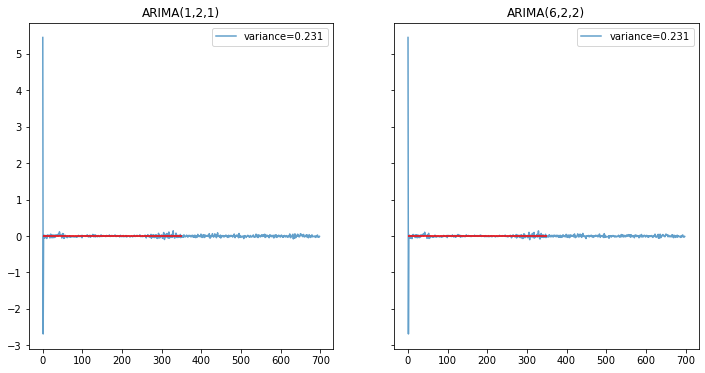

In [94]:
model = ARIMA(endog=np.log(timeseries).dropna(), order=(1, 2, 1))
res_000 = model.fit()
print(res_000.summary())

model = ARIMA(endog=np.log(timeseries).dropna(), order=(6, 2, 2))
res_010 = model.fit()
print(res_010.summary())

fig, ax = plt.subplots(1, 2, sharey=True, figsize=(12, 6))
ax[0].plot(res_000.resid.values, alpha=0.7, label='variance={:.3f}'.format(np.std(res_000.resid.values)))
ax[0].hlines(0, xmin=0, xmax=350, color='r')
ax[0].set_title("ARIMA(1,2,1)")
ax[0].legend()
ax[1].plot(res_010.resid.values, alpha=0.7, label='variance={:.3f}'.format(np.std(res_010.resid.values)))
ax[1].hlines(0, xmin=0, xmax=350, color='r')
ax[1].set_title("ARIMA(6,2,2)")
ax[1].legend()

prediction

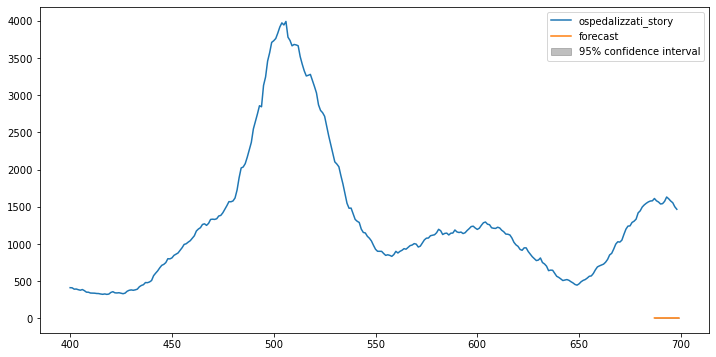

In [106]:
model = ARIMA(endog=np.log(timeseries).dropna()[:-12], order=(1,2,2))
res_111 = model.fit()

fig, ax = plt.subplots(figsize=(12, 6))
timeseries[400:].plot(ax=ax)

ax = plot_predict(res_111, start=687, end=699, dynamic=True, plot_insample=False, ax=ax)